# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
<b>Признаки:</b> </p>
DateCrawled — дата скачивания анкеты из базы </p>
VehicleType — тип автомобильного кузова </p>
RegistrationYear — год регистрации автомобиля </p>
Gearbox — тип коробки передач </p>
Power — мощность (л. с.) </p>
Model — модель автомобиля </p>
Kilometer — пробег (км) </p>
RegistrationMonth — месяц регистрации автомобиля </p>
FuelType — тип топлива </p>
Brand — марка автомобиля </p>
Repaired — была машина в ремонте или нет </p>
DateCreated — дата создания анкеты </p>
NumberOfPictures — количество фотографий автомобиля </p>
PostalCode — почтовый индекс владельца анкеты (пользователя) </p>
LastSeen — дата последней активности пользователя </p>

<b>Целевой признак:</b> </p>
Price — цена (евро) </p>

## Подготовка данных

Изучим наши данные

In [1]:
%matplotlib inline

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

import lightgbm as lgb

from lightgbm import LGBMRegressor

import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv(r"C:\Users\User\Autos\autos.csv")
except:
    data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Приведем названия столбцов к нижнему змеиному регистру

In [5]:
data.columns = data.columns.str.replace('([A-Z])', r'_\1').str.lower().str.replace('_', '', 1)
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Удалим из таблицы столбцы, которые не понадобятся для обучения модели

In [6]:
data = data.drop(['date_crawled', 'last_seen', 'postal_code', 'number_of_pictures', 'date_created', 'registration_month'], axis=1)

Найдем дубликаты и удалим их, если таковые имеются

In [7]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

Есть предположение, что тип автомобиля, коробка передач, модель, тип топлива и факт ремонта могут быть пустыми, т.к. пользователь не указал их при заполнении анкеты. Удалять не будем. Заполним пропуски в этих столбцах значением "unknown". </p> 
- Заменим значение petrol на gasoline в столбце fuel_type, т.к. это одно и то же.
- Заменим значение other на unknown в столбце vehicle_type для стандартизации данных.

In [8]:
data['fuel_type'] = data['fuel_type'].replace('petrol', 'gasoline').fillna('unknown')
data['vehicle_type'] = data['vehicle_type'].replace('other', 'unknown').fillna('unknown')
data['model'] = data['model'].fillna('unknown')
data['gearbox'] = data['gearbox'].fillna('unknown')
data['repaired'] = data['repaired'].fillna('unknown')

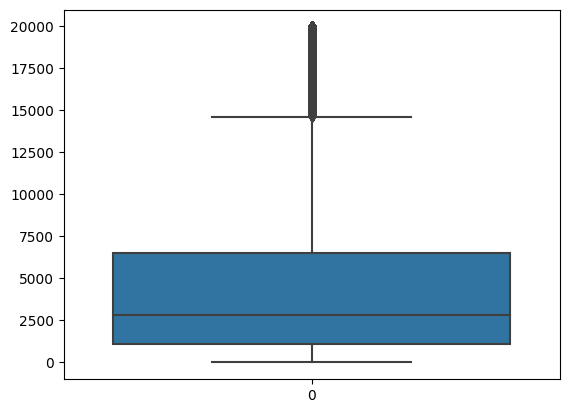

count    309329.000000
mean       4486.937196
std        4564.852796
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [9]:
sns.boxplot(data['price'])
plt.show()
data['price'].describe()

Уберем данные об автомобилях с ценой менее 100 евро, т.к. такая цена маловероятна в реальной жизни

In [10]:
data = data[data['price'] >= 100]

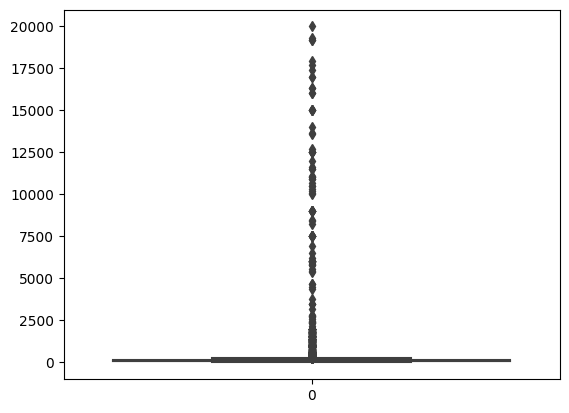

count    298048.000000
mean        112.146648
std         199.304518
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [11]:
sns.boxplot(data['power'])
plt.show()
data['power'].describe()

Удалим значения больше 500 л.с., т.к. это явные выбросы. Нули удалять не будем, т.к. это могут быть автомобили не на ходу.

In [12]:
data = data[data['power'] <= 500]


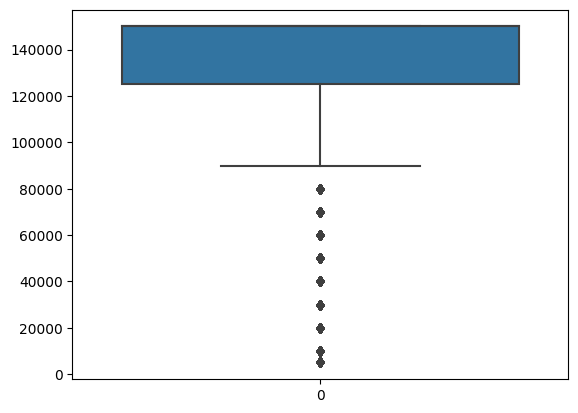

count    297637.000000
mean     127472.575654
std       37932.977849
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [13]:
sns.boxplot(data['kilometer'])
plt.show()
data['kilometer'].describe()

Здесь видим значения пробега от 5000 до 150000 км, что нормально. Удалять не будем.

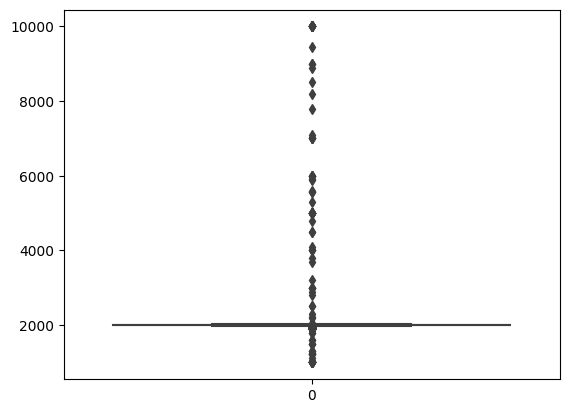

count    297637.000000
mean       2004.099107
std          73.725995
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [14]:
sns.boxplot(data['registration_year'])
plt.show()
data['registration_year'].describe()

Уберем также явно неадекватные значения года регистрации автомобиля.

In [15]:
data = data[data['registration_year'] >= 1883 & (data['registration_year'] <= 2022)]

Выводы по разделу: <p>
- Столбцы привели к нижнему змеиному регистру <p>
- Пропуски в данных заполнены значением "unknown" <p>
- Дубликаты удалены <p>
- Столбцы, ненужные для обучения модели, удалены <p>
- Синонимичные определения petrol и gasoline объединены в одно <p>
- Некорректные значения удалены <p>

## Обучение моделей

Проведем подготовку нашего датасета для обучения моделей

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297637 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              297637 non-null  int64 
 1   vehicle_type       297637 non-null  object
 2   registration_year  297637 non-null  int64 
 3   gearbox            297637 non-null  object
 4   power              297637 non-null  int64 
 5   model              297637 non-null  object
 6   kilometer          297637 non-null  int64 
 7   fuel_type          297637 non-null  object
 8   brand              297637 non-null  object
 9   repaired           297637 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.0+ MB


In [17]:
data = data.reset_index(drop=True)

In [18]:
X = data.drop('price', axis=1)
y = data['price']

X_data, X_valid, y_data, y_valid = (train_test_split(
    X, y, test_size=0.20, random_state=1000)) 

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=1000)

In [19]:
cat = list(X_train.select_dtypes(include='object').columns)
num = list(X_train.select_dtypes(exclude='object').columns)

cat, num

(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'],
 ['registration_year', 'power', 'kilometer'])

In [20]:
encoder = OrdinalEncoder()
encoder.fit(X_train[cat])

X_train[cat] = encoder.transform(X_train[cat])
X_valid[cat] = encoder.transform(X_valid[cat])
X_test[cat] = encoder.transform(X_test[cat])

print(X_train.columns)
print(X_valid.columns)
print(X_test.columns)

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')
Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')
Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')


In [21]:
scaler = StandardScaler()
scaler.fit(X_train[num])

features_train_scaled = pd.DataFrame(scaler.transform(X_train[num]), columns=num, index=X_train.index)
features_test_scaled = pd.DataFrame(scaler.transform(X_test[num]), columns=num, index=X_test.index)
features_valid_scaled = pd.DataFrame(scaler.transform(X_valid[num]), columns=num, index=X_valid.index)

features_train_scaled.head()

,registration_year,power,kilometer
186714,-0.027776,-0.114322,0.593399
125928,-0.066136,-1.718915,0.593399
157083,-0.091710,0.266967,0.593399
283757,0.010584,4.572359,-0.067582
285135,-0.040563,0.219306,0.593399


Также напишем функции для вычисления итогового времени обучения и предсказания моделей

In [22]:
def fit_model_time(model, features, target):

    start = time.time()
    model.fit(features, target)       
    end = time.time()
    
    return {'model':model, 'fit_time':(end-start)}

In [23]:
def predict_model_time(model, features):

    start = time.time()
    predictions = model.predict(features)
    end = time.time()
    
    return {'predictions':predictions, 'prediction_time':(end-start)}

In [24]:
def show_metrics(fit_model_time, predict_model_time, rmse):

    print('Время обучения:', fit_model_time)
    print('Время предсказания:', predict_model_time)
    print('RMSE =', rmse)

Создадим сетку параметров для моделей

In [25]:
params = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.1, 0.15, 0.2],
    'n_estimators': [10, 100],
}

И сравнительную таблицу для результатов

In [26]:
model_comparison = pd.DataFrame(columns=['Модель', 'RMSE', 'Время обучения', 'Время предсказания'])

Обучим модели и запишем результаты в таблицу

In [27]:
l_rate_rf = 0
n_est_rf = 0
m_depth_rf = 0
rmse_rf = 2500
predict_time_rf = 10
fit_time_rf = 10

for learning_rate in params['learning_rate']:
    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            rf_model = RandomForestRegressor(random_state=12345, n_jobs=-1, verbose=0)
            fit = fit_model_time(rf_model, X_train, y_train)
            predict = predict_model_time(rf_model, X_valid)
            rmse = mean_squared_error(y_valid, predict.get('predictions'), squared=False)
            show_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

            if rmse <= rmse_rf:
                rmse_rf = rmse
                if predict.get('prediction_time') < predict_time_rf:
                    predict_time_rf = predict.get('prediction_time')
                    if fit.get('fit_time') < fit_time_rf:
                        fit_time_rf = fit.get('fit_time')
                        l_rate_rf = learning_rate
                        n_est_rf = n_estimators
                        m_depth_rf = max_depth

print(' ')
print('Наилучшие параметры:')
print('learning_rate =', l_rate_rf)
print('n_estimators =', n_est_rf)
print('max_depth =', m_depth_rf)
print(' ')
print(f'RMSE при данных параметрах: {rmse_rf}')

model_comparison = model_comparison.append({'Модель':rf_model, 'RMSE':rmse_rf, 'Время обучения':fit_time_rf, 'Время предсказания':predict_time_rf}, ignore_index=True)
rf_best_params = {'learning_rate':l_rate_rf, 'n_estimators':n_est_rf, 'max_depth':m_depth_rf}

Время обучения: 5.133943557739258
Время предсказания: 0.32167720794677734
RMSE = 1787.3298321588559
Время обучения: 5.187960624694824
Время предсказания: 0.33637428283691406
RMSE = 1787.3298321588559
Время обучения: 5.176274538040161
Время предсказания: 0.3248629570007324
RMSE = 1787.3298321588559
Время обучения: 4.850126504898071
Время предсказания: 0.34702157974243164
RMSE = 1787.3298321588559
Время обучения: 4.76390266418457
Время предсказания: 0.3276793956756592
RMSE = 1787.3298321588559
Время обучения: 4.69149374961853
Время предсказания: 0.31837034225463867
RMSE = 1787.3298321588559
Время обучения: 4.591450214385986
Время предсказания: 0.32259702682495117
RMSE = 1787.3298321588559
Время обучения: 4.765275716781616
Время предсказания: 0.32573795318603516
RMSE = 1787.3298321588559
Время обучения: 4.521566867828369
Время предсказания: 0.3216378688812256
RMSE = 1787.3298321588559
Время обучения: 4.561999797821045
Время предсказания: 0.3094935417175293
RMSE = 1787.3298321588559
Время 

In [28]:
l_rate_lgbm = 0
n_est_lgbm = 0
m_depth_lgbm = 0
rmse_lgbm = 2500
predict_time_lgbm = 10
fit_time_lgbm = 10

for learning_rate in params['learning_rate']:
    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            lgbm_model = LGBMRegressor(random_state=12345, n_jobs=-1)
            fit = fit_model_time(lgbm_model, X_train, y_train)
            predict = predict_model_time(lgbm_model, X_valid)
            rmse = mean_squared_error(y_valid, predict.get('predictions'), squared=False)
            show_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

            if rmse <= rmse_lgbm:
                rmse_lgbm = rmse
                if predict.get('prediction_time') < predict_time_lgbm:
                    predict_time_lgbm = predict.get('prediction_time')
                    if fit.get('fit_time') < fit_time_lgbm:
                        fit_time_lgbm = fit.get('fit_time')
                        l_rate_lgbm = learning_rate
                        n_est_lgbm = n_estimators
                        m_depth_lgbm = max_depth

print(' ')
print('Наилучшие параметры:')
print('learning_rate =', l_rate_lgbm)
print('n_estimators =', n_est_lgbm)
print('max_depth =', m_depth_lgbm)
print(' ')
print(f'RMSE при данных параметрах: {rmse_lgbm}')

model_comparison = model_comparison.append({'Модель':lgbm_model, 'RMSE':rmse_lgbm, 'Время обучения':fit_time_lgbm, 'Время предсказания':predict_time_lgbm}, ignore_index=True)
lgbm_best_params = {'learning_rate':l_rate_lgbm, 'n_estimators':n_est_lgbm, 'max_depth':m_depth_lgbm}

Время обучения: 0.23617935180664062
Время предсказания: 0.029085874557495117
RMSE = 1804.8394048803762
Время обучения: 0.26013779640197754
Время предсказания: 0.034093618392944336
RMSE = 1804.8394048803762
Время обучения: 0.2589986324310303
Время предсказания: 0.029166460037231445
RMSE = 1804.8394048803762
Время обучения: 0.25955796241760254
Время предсказания: 0.028628826141357422
RMSE = 1804.8394048803762
Время обучения: 0.24897193908691406
Время предсказания: 0.029098987579345703
RMSE = 1804.8394048803762
Время обучения: 0.25406527519226074
Время предсказания: 0.028757333755493164
RMSE = 1804.8394048803762
Время обучения: 0.25095319747924805
Время предсказания: 0.029079914093017578
RMSE = 1804.8394048803762
Время обучения: 0.2589888572692871
Время предсказания: 0.02916240692138672
RMSE = 1804.8394048803762
Время обучения: 0.25267672538757324
Время предсказания: 0.02845454216003418
RMSE = 1804.8394048803762
Время обучения: 0.2469625473022461
Время предсказания: 0.02805018424987793
RM

In [29]:
l_rate_cb = 0
n_est_cb = 0
m_depth_cb = 0
r_mse_cb = 2500
predict_time_cb = 10
fit_time_cb = 20

for learning_rate in params['learning_rate']:
    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            cb_model = CatBoostRegressor(random_state=12345, verbose=False)
            fit = fit_model_time(cb_model, X_train, y_train)
            predict = predict_model_time(cb_model, X_valid)
            rmse = mean_squared_error(y_valid, predict.get('predictions'), squared=False)
            show_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

            if rmse <= r_mse_cb:
                r_mse_cb = rmse
                if predict.get('prediction_time') < predict_time_cb:
                    predict_time_cb = predict.get('prediction_time')
                    if fit.get('fit_time') < fit_time_cb:
                        fit_time_cb = fit.get('fit_time')
                        l_rate_cb = learning_rate
                        n_est_cb = n_estimators
                        m_depth_cb = max_depth

print(' ')
print('Наилучшие параметры:')
print('learning_rate =', l_rate_cb)
print('n_estimators =', n_est_cb)
print('max_depth =', m_depth_cb)
print(' ')
print(f'RMSE при данных параметрах: {r_mse_cb}')

model_comparison = model_comparison.append({'Модель':cb_model, 'RMSE':r_mse_cb, 'Время обучения':fit_time_cb, 'Время предсказания':predict_time_cb}, ignore_index=True)
cb_best_params = {'learning_rate':l_rate_cb, 'n_estimators':n_est_cb, 'max_depth':m_depth_cb}

Время обучения: 10.204902410507202
Время предсказания: 0.008463144302368164
RMSE = 1724.956217817646
Время обучения: 9.769944190979004
Время предсказания: 0.009379863739013672
RMSE = 1724.956217817646
Время обучения: 9.797580480575562
Время предсказания: 0.004953145980834961
RMSE = 1724.956217817646
Время обучения: 9.773490190505981
Время предсказания: 0.02433609962463379
RMSE = 1724.956217817646
Время обучения: 9.796773195266724
Время предсказания: 0.017943143844604492
RMSE = 1724.956217817646
Время обучения: 9.751928806304932
Время предсказания: 0.0065042972564697266
RMSE = 1724.956217817646
Время обучения: 9.864466428756714
Время предсказания: 0.018080711364746094
RMSE = 1724.956217817646
Время обучения: 9.81490707397461
Время предсказания: 0.008582115173339844
RMSE = 1724.956217817646
Время обучения: 9.793201446533203
Время предсказания: 0.011103630065917969
RMSE = 1724.956217817646
Время обучения: 9.840057373046875
Время предсказания: 0.009177684783935547
RMSE = 1724.956217817646


## Анализ моделей

Посмотрим на результаты работы моделей

In [30]:
model_comparison

,Модель,RMSE,Время обучения,Время предсказания
0,"(DecisionTreeRegressor(max_features=1.0, rando...",1787.329832,4.562000,0.302334
1,LGBMRegressor(random_state=12345),1804.839405,0.236179,0.026995
2,<catboost.core.CatBoostRegressor object at 0x0...,1724.956218,9.797580,0.004953


Самой быстрой по времени обучения оказалась LGBMRegressor, а самой точной, исходя из метрики RMSE оказалась CatBoostRegressor. Вторая, также, показала лучший результат по времени предсказания. <p>
Если учитывать то, что для задачи нужно составить модель один раз, чтобы она в дальнейшем использовалась для быстрого предсказания, то лучшей моделью будет CatBoostRegressor. <p>

# Тестирование лучшей модели

In [31]:
test_cb_model = CatBoostRegressor(cb_best_params, random_state=12345, verbose=False)
fit = fit_model_time(cb_model, X_train, y_train)
predict = predict_model_time(cb_model, X_test)
rmse = mean_squared_error(y_test, predict.get('predictions'), squared=False)
show_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

Время обучения: 9.738242864608765
Время предсказания: 0.010925531387329102
RMSE = 1690.207570836713


На тестовой выборке наша модель показала следующий результат:
- RMSE = 1690
- Скорость предсказания ~ 0.01 секунды
- Скорость обучения ~ 10 секунд

Если требования заказчика указаны в порядке приоритета - результат работы данной модели можно считать валидным для нашей задачи, т.к. среди упомянутых выше моделей, кэтбуст показывает минимальный результат по количеству ошибок и самую высокую скорость предсказания. <p>
На тестовой выборке также были получены прекрасные результаты, которые подтвердили качество работы модели.